In [2]:
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, LSTM, Flatten, Embedding, LeakyReLU
from keras.utils import to_categorical
from keras.backend import clear_session

import pandas as pd
import numpy as np
import os

In [3]:
# load Google's pre-trained word2vec embeddings
word2vec_file = "/Users/ryanle/Desktop/GTSpring2021/CS4440/Project/NLP/GoogleNews-vectors-negative300.bin"
google_embeddings = KeyedVectors.load_word2vec_format(word2vec_file, binary=True)

In [4]:
print("Len: {}".format(google_embeddings["hello"].shape)) # array of (300000, 300)

Len: (300,)


In [5]:
# load Stanford's pre-trained GloVe embeddings
glove_file = "/Users/ryanle/Desktop/GTSpring2021/CS4440/Project/NLP/glove/glove.6B/glove.6B.300d.txt"
glove_word2vec_file = "/Users/ryanle/Desktop/GTSpring2021/CS4440/Project/NLP/glove/glove.6B/glove.6B.100d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

<ipython-input-5-91f7faadf958>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, glove_word2vec_file)


(400001, 300)

In [6]:
# glove embeddings
glove_embeddings = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)


In [7]:
# personal / professional dir
#pp_dir = "/Users/ryanle/Desktop/GTSpring2021/CS4440/Project/Dataset/professional_personal.csv"
pp_dir = "/Users/ryanle/Desktop/GTSpring2021/CS4440/Project/Dataset/professional_personal_v2.csv"


In [8]:
# load data
data = pd.read_csv(pp_dir)


In [9]:
data.head()


,date,X-Folder,X-From,X-To,text
0,13-12-2000 08:56:00,Personal,"""Dell Computer Corp."" <LB_Electronic_Orders@de...","""jennifer.medcalf@enron.com"" <jennifer.medcalf...",dell order confirmation dear jennifer medcalf...
1,14-12-2000 04:55:00,Personal,James Wininger,Jennifer Medcalf,brown bag thank dear jennifer thank hosting b...
2,14-12-2000 04:58:00,Personal,Jerome_Alder@Dell.com,jennifer.medcalf@enron.com,dell online order dell enron clickathome orde...
3,14-12-2000 05:22:00,Personal,Colleen Koenig,Jennifer Medcalf,update attendees brown bags 12 13 12 14 notic...
4,15-12-2000 00:32:00,Personal,Jennifer N Stewart,Jennifer Medcalf,confirmation order 3253472 hope well forwarde...


In [10]:
# side of each folder
data["X-Folder"].value_counts()

Professional    2485
Personal        2485
Name: X-Folder, dtype: int64

In [11]:
# encoding class labels
data["X-Folder"].unique()

array(['Personal', 'Professional'], dtype=object)

In [12]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['X-Folder'])
    return y

In [13]:
y = label_encoder(data)
input_data = data['text']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(input_data, y, test_size=0.2)

In [63]:
# removing biases
from random import randint 

def remove_bias(x, y):
    zeros = np.count_nonzero(y == 0)
    ones = np.count_nonzero(y == 1)
    print("Before Zero: {}, Ones: {}".format(zeros, ones))
    drop_indices = []
    x = x.to_numpy()    
    difference = ones - zeros  # subtract from here to change the bias
    if difference > 0:
        ones_index = np.where(y == 1)[0]
        drop_indices = np.random.choice(ones_index, difference, replace=False)
    elif difference < 0:
        zeros_index = np.where(y == 0)[0]
        drop_indices = np.random.choice(zeros_index, -difference, replace=False)
    x = np.delete(x, drop_indices)
    x = pd.Series(x)
    y = np.delete(y, drop_indices)
    zeros = np.count_nonzero(y == 0)
    ones = np.count_nonzero(y == 1)
    print("After Zero: {}, Ones: {}".format(zeros, ones))
    return x, y

In [64]:
# removing biases 
print("Before - X train: {}, Y train: {}, X test: {}, Y test: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
X_train, y_train = remove_bias(X_train, y_train)
X_test, y_test = remove_bias(X_test, y_test)
print("After - X train: {}, Y train: {}, X test: {}, Y test: {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))


Before - X train: (3976,), Y train: (3976,), X test: (994,), Y test: (994,)
Before Zero: 2003, Ones: 1973
After Zero: 1973, Ones: 1973
Before Zero: 482, Ones: 512
After Zero: 482, Ones: 482
After - X train: (3946,), Y train: (3946,), X test: (964,), Y test: (964,)


In [66]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y_test, 2)


In [265]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data) # input_data == Series
vocab_size = len(t.word_index) + 1

# integer encode the documents
X_train_encoded_docs = t.texts_to_sequences(X_train)
X_test_encoded_docs = t.texts_to_sequences(X_test)

In [68]:
# pad documents to a max length of 150 words
max_length = 150
X_train_padded_docs = pad_sequences(X_train_encoded_docs, maxlen=max_length, padding='post')
X_test_padded_docs = pad_sequences(X_test_encoded_docs, maxlen=max_length, padding='post')

print(X_train_padded_docs[0])


[  524   157  1236   134  1017   286   368  1855   631   658  1660  7765
   524   458  1726    81   893  6821    86  1202   469   101   227  3753
  1015  5514   372   124  1136  1874   376  3675 12233  4393  4877 26624
  1144  1261  1600  3676   111   395  1600  1003   419   285  7217   192
  5773  9048 26625   458  1051  4243   101  9049  3516 26626  1391  1409
   180    13    69   285   125  1996   157 19634  3235   582 11014   481
   101  7235  5263   524  1726   458  1236    49  3643    13   362  1207
 19635   988   328   383  1319   135  1232  1236  1175    45  1007  1319
   286   855    86  8356 26627   253  1136  4877   204  1682  2355    91
    73   395   681   581   249   160     5  3539   286   681   527    30
  1136  1099   967   794  4878    18  6822   664  3290   780     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


In [69]:
X_train_padded_docs.shape
y_train[:10]


array([0, 1, 1, 1, 0, 1, 0, 0, 1, 0])

## Google word2vec

In [151]:
# using google word embeddings
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = google_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [184]:
def create_model():
    # define the model
    model = Sequential()
    e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
    model.add(e)
    model.add(LSTM(100, dropout=0.2)) # reduce layer to 100 -> 75 -> 50 -> 25. Try to add ReLU activation function
    #model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(2, activation='sigmoid'))


    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # summarize the model
    model.summary()
    return model

In [155]:
# google model
model_google = create_model()
history_google = model_google.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1) 


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 150, 300)          12743100  
_________________________________________________________________
lstm_15 (LSTM)               (None, 75)                112800    
_________________________________________________________________
flatten_15 (Flatten)         (None, 75)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 152       
Total params: 12,856,052
Trainable params: 112,952
Non-trainable params: 12,743,100
_________________________________________________________________
Epoch 1/60
111/111 [==============================] - 13s 94ms/step - loss: 0.6741 - accuracy: 0.5567 - val_loss: 0.6444 - val_accuracy: 0.5747
Epoch 2/60
111/111 [==============================] - 9s 85ms/step - loss: 0.6463 - accur

111/111 [==============================] - 12s 110ms/step - loss: 0.4378 - accuracy: 0.8204 - val_loss: 0.4747 - val_accuracy: 0.7823
Epoch 52/60
111/111 [==============================] - 12s 105ms/step - loss: 0.4143 - accuracy: 0.8328 - val_loss: 0.4132 - val_accuracy: 0.8203
Epoch 53/60
111/111 [==============================] - 17s 154ms/step - loss: 0.3772 - accuracy: 0.8441 - val_loss: 0.4140 - val_accuracy: 0.8253
Epoch 54/60
111/111 [==============================] - 15s 130ms/step - loss: 0.3404 - accuracy: 0.8622 - val_loss: 0.3894 - val_accuracy: 0.8278
Epoch 55/60
111/111 [==============================] - 13s 121ms/step - loss: 0.3401 - accuracy: 0.8573 - val_loss: 0.3883 - val_accuracy: 0.8228
Epoch 56/60
111/111 [==============================] - 15s 139ms/step - loss: 0.3355 - accuracy: 0.8585 - val_loss: 0.3839 - val_accuracy: 0.8354
Epoch 57/60
111/111 [==============================] - 11s 99ms/step - loss: 0.3066 - accuracy: 0.8695 - val_loss: 0.3865 - val_accuracy

In [156]:
# google vector accuracy
accuracy_google = model_google.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accuracy_google[0], accuracy_google[1]))

31/31 [==============================] - 1s 30ms/step - loss: 0.3998 - accuracy: 0.8299
Test Set: 
 Loss: 0.400
 Accuracy: 0.830


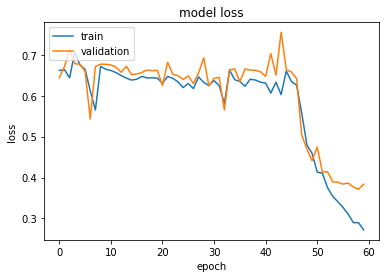

In [157]:
# google vectors

# "Loss"
plt.plot(history_google.history['loss'])
plt.plot(history_google.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

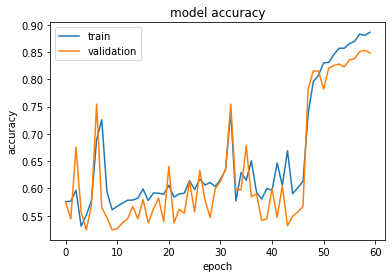

In [158]:
# google vectors

# "Accuracy"
plt.plot(history_google.history['accuracy'])
plt.plot(history_google.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Glove vector

In [183]:
# glove vector model
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [185]:
# glove vector model
model_glove = create_model()
history_glove = model_glove.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1)



Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 150, 300)          12743100  
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               160400    
_________________________________________________________________
flatten_20 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 12,903,702
Trainable params: 160,602
Non-trainable params: 12,743,100
_________________________________________________________________
Epoch 1/60
111/111 [==============================] - 14s 110ms/step - loss: 0.6508 - accuracy: 0.5872 - val_loss: 0.5906 - val_accuracy: 0.7063
Epoch 2/60
111/111 [==============================] - 11s 101ms/step - loss: 0.5659 - ac

111/111 [==============================] - 11s 98ms/step - loss: 0.1947 - accuracy: 0.9368 - val_loss: 0.4429 - val_accuracy: 0.8582
Epoch 52/60
111/111 [==============================] - 10s 92ms/step - loss: 0.1285 - accuracy: 0.9607 - val_loss: 0.4775 - val_accuracy: 0.8329
Epoch 53/60
111/111 [==============================] - 10s 94ms/step - loss: 0.1033 - accuracy: 0.9724 - val_loss: 0.4547 - val_accuracy: 0.8456
Epoch 54/60
111/111 [==============================] - 10s 93ms/step - loss: 0.1009 - accuracy: 0.9729 - val_loss: 0.4558 - val_accuracy: 0.8380
Epoch 55/60
111/111 [==============================] - 10s 94ms/step - loss: 0.0940 - accuracy: 0.9754 - val_loss: 0.5080 - val_accuracy: 0.8405
Epoch 56/60
111/111 [==============================] - 11s 99ms/step - loss: 0.0839 - accuracy: 0.9771 - val_loss: 0.4476 - val_accuracy: 0.8456
Epoch 57/60
111/111 [==============================] - 11s 97ms/step - loss: 0.0786 - accuracy: 0.9733 - val_loss: 0.4779 - val_accuracy: 0.84

In [246]:
\

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 150, 300)          12743100  
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               160400    
_________________________________________________________________
flatten_20 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 12,903,702
Trainable params: 160,602
Non-trainable params: 12,743,100
_________________________________________________________________


In [186]:
# evaluate the model2 on the test set
accuracy_glove = model_glove.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accuracy_glove[0], accuracy_glove[1]))

31/31 [==============================] - 1s 35ms/step - loss: 0.5302 - accuracy: 0.8496
Test Set: 
 Loss: 0.530
 Accuracy: 0.850


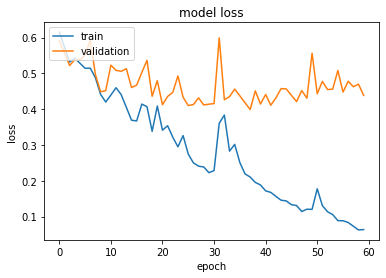

In [187]:
# glove vectors

# "Loss"
plt.plot(history_glove.history['loss'])
plt.plot(history_glove.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

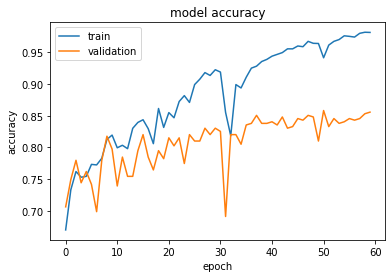

In [188]:
# glove vectors

# "Accuracy"
plt.plot(history_glove.history['accuracy'])
plt.plot(history_glove.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [205]:
# test accuracy on personal vs professional emails
predictions = model_glove.predict(X_test_padded_docs) 

In [206]:
predictions[:10]

array([[9.9064553e-01, 1.0103315e-02],
       [7.8870505e-02, 9.2183578e-01],
       [4.5549572e-03, 9.9549901e-01],
       [1.2524724e-03, 9.9875617e-01],
       [1.5828192e-02, 9.8445237e-01],
       [9.9924815e-01, 5.0842762e-04],
       [4.9803001e-01, 5.0369596e-01],
       [9.5876604e-01, 3.9072931e-02],
       [1.5236139e-02, 9.8098779e-01],
       [4.6177506e-03, 9.9542117e-01]], dtype=float32)

In [207]:
y_test[:10]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1])

In [216]:
def get_accuracy(predictons, y_test):
    prof = 0
    pers = 0
    num_each = len(y_test) / 2
    for i in range(len(predictions)):
        if predictions[i][0] > predictions[i][1] and y_test[i] == 0:
            pers += 1
        elif predictions[i][0] < predictions[i][1] and y_test[i] == 1:
            prof += 1
    return (prof / float(num_each), pers / float(num_each))
    

In [217]:
prof, pers = get_accuracy(predictions, y_test)

In [218]:
print("prof: {}".format(prof))
print("pers: {}".format(pers))

prof: 0.8298755186721992
pers: 0.8692946058091287


### Results with original dataset

In [ ]:
'''
LSTM with 100 nodes
Results - Google:(with original file)
- Adam: 0.854 accuracy, 0.508 loss
- RMSProp: 0.879 accuracy, 0.468 loss
Results - GloVe:(with original file)
- Adam: 0.876 accuracy, 0.349 loss  
- RMSProp: 0.884 accuracy, 0.581 loss 


LSTM with 75 nodes
Results - Google:(with original file)
- Adam: 0.859 accuracy, 0.374 loss
- RMSProp: 0.882 accuracy, 0.500 loss 
Results - GloVe:(with original file)
- Adam: 0.882 accuracy, 0.463 loss  
- RMSProp:0.877 accuracy, 0.507 loss


LSTM with 50 nodes
Results - Google:(with original file)
- Adam: 0.846 accuracy, 0.379 loss
- RMSProp: 0.869 accuracy 0.504 loss
Results - GloVe:(with original file)
- Adam: 0.872 accuracy, 0.498 loss
- RMSProp: 0.879 accuracy, 0.476 loss  
'''

### Results with other dataset

In [ ]:
'''
LSTM with 100 nodes
Results - Google:(with new file)
- Adam: 0.829 accuracy, 0.422 loss
- RMSProp: 0.794 accuracy, 0.524 loss

Results - GloVe:
- Adam: 0.863 accuracy, 0.551 loss
- RMSProp: 0.851 accuracy, 0.608 loss

LSTM with 90 nodes
Results - GloVe:
- Adam: 0.853 accuracy, 0.512 loss 



LSTM with 75 nodes
Results - Google:(with new file)
- Adam:  0.830 accuracy, 0.400 loss
- RMSProp: 

Results - GloVe:
- Adam: 0.853 accuracy, 0.417 loss
- RMSProp: 0.835 accuracy, 0.486 loss # udated 


LSTM with 50 nodes
Results - Google:(with original file)
- Adam:  
- RMSProp: 
Results - GloVe:(with original file)
- Adam: 
- RMSProp:
'''
'''
Ideas:4
- use only the "personal" xfolder 
- try different folders 
'''

## Saving model with Best Performance

In [269]:
# model: GLoVe model with adam optimizer, 100 nodes, second dataset 
model_glove.save("personal_professional.h5")


In [270]:
# loading model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('personal_professional.h5')
# summarize model.
model.summary()


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 150, 300)          12743100  
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               160400    
_________________________________________________________________
flatten_20 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
Total params: 12,903,702
Trainable params: 160,602
Non-trainable params: 12,743,100
_________________________________________________________________


In [271]:
accuracy = model.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accuracy[0], accuracy[1]))

31/31 [==============================] - 2s 46ms/step - loss: 0.5302 - accuracy: 0.8496
Test Set: 
 Loss: 0.530
 Accuracy: 0.850


In [272]:
# imports
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# data cleaning
import re
import string
from nltk.corpus import stopwords



In [286]:
# prepare tokenizer
pp_dir = "/Users/ryanle/Desktop/GTSpring2021/CS4440/Project/CS4440_project/ML/RyanLe/professional_personal_v2.csv"

# load data
data = pd.read_csv(pp_dir)
input_data = data['text']

t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data) # input_data == Series
vocab_size = len(t.word_index) + 1

In [287]:
input_data.shape

(4970,)

In [282]:
def clean(x):
    # lowercasing all the words
    x = x.lower()
    
    # remove extra new lines
    x = re.sub(r'\n+', ' ', x)
    
    # removing (replacing with empty spaces actually) all the punctuations
    x = re.sub("["+string.punctuation+"]", " ", x)
    
    # remove extra white spaces
    x = re.sub(r'\s+', ' ', x)
    
    stop = stopwords.words('english')
    new = ""
    for word in x.split():
        if word not in stop:
            new+= " " + word
    return new


In [303]:
def preprocess(x):
    email = [clean(x)]
    # integer encode the documents    
    email_encoded_docs = t.texts_to_sequences(email)
    max_length = 150
    # pad documents to a max length of 150 words
    text = pad_sequences(email_encoded_docs, maxlen=max_length, padding='post')
    return text


In [304]:
def ppModel(email):
    body = email["body"] # this will reference the body of the email
    subject = email["subject"] # this will reference the subject of the email
    text = subject + " " + body
    preprocessed = [preprocess(text)]
    output = model.predict(preprocessed)
    #print("Output: {}".format(output))
    if (output[0][0] > output[0][1]):
        return "True"
    return "False"


### Manual Tests

In [313]:
x = {"subject": "VACATION", 
     "body": "Jeff, I received the rent roll.  I am going to be in San Marcos this weekend but I  am booked with stage coach.  I will drive by Friday evening. I will let you know next week if I need to see the inside.  Can you find out when Chelsea Villa last changed hands and for what price? What about getting a look at the site plans for the Burnet deal.  Remember  we have to get Brenda happy. Phillip"}

In [299]:
x =  {"subject": "Re: Meeting to discuss 2001 direct expense plan?", 
     "body": "Suzanne, Can you give me more details or email  the plan prior to meeting?  What do I need to provide besides headcount? Otherwise any afternoon next week would be fine Phillip"}

In [305]:
x = {"subject": "Re: VaR by Curve",
    "body": "why is aeco basis so low on the list?  Is NWPL mapped differently than AECO? What about the correlation to Nymex on AECO?" }




In [307]:
x = {"subject": "Hello",
     "body": "' enron astroworld tickets enron announces unlimited discounted astroworld tickets employees due overwhelming employee feedback negotiated unlimited discounted astroworld tickets family place traditional enron day astroworld hope allow enron families plan fun filled summer trips astroworld convenience enron astroworld tickets 20 56 retail 50 includes admission one plus 7 meal ticket one five restaurants astroworld six flags astroworld world class family entertainment complex filled exciting rides attractions including 10 heart pounding coasters 40 blockbuster shows interactive street entertainers star studded concerts enron families able purchase unlimited tickets use anytime 2001 season tickets sale enron federal credit union eb0399 visit credit union person make purchases astroworld tickets mailed enron employees already enron fcu members may pay cash money order enron employees encouraged take advantage great summer fun deal may purchase tickets august 30th'"
}

In [291]:
x = {"subject": "",
     "body": ' neon material week sep 27 leaders three things week material probably way much stuff use even try pick things questions feel important hit group best remember material one part needs happening neon group getting know share critical use one icebreaker activities even seems cheesy somehow ask questions get group talking see note material cd neon box finally let know new leaders working us specifically carol poe backors neon silver leslie debbie bills welcome debbie les keep great work bobby neon measuring success lesson 2 doc'

    }

In [318]:
x = {"subject": "Family fun",
     "body": "Dear Leslie, Hope you are doing well. Recently, I had the pleasure of seeing your daughter play the piano at the elementary school concert. I have long been interested in enrolling my son Daniel in lessons as well. Where did your daughter learn piano lessons? Can you forward any contacts? Thanks, Aiden Framingham."
    
}

In [317]:
# debugging

professional_count = 0
personal_count = 0
for i in range(len(X_test)):
    temp = {}
    temp["subject"] = ""
    temp["body"] = X_test[i]
    output = ppModel(temp)
    # is personal 
    if output == "True" and y_test[i] == 0:
        personal_count+=1
    elif output == "True" and y_test[i] == 1:
        professional_count+=1
print(personal_count)

Output: [[0.9906454  0.01010332]]
Output: [[0.07887062 0.92183566]]
Output: [[0.00455493 0.995499  ]]
Output: [[0.00125247 0.9987563 ]]
Output: [[0.01582822 0.98445225]]
Output: [[9.9924815e-01 5.0842762e-04]]
Output: [[0.49803028 0.50369555]]
Output: [[0.95876604 0.03907287]]
Output: [[0.01523617 0.98098785]]
Output: [[0.00461775 0.99542105]]
Output: [[0.6418736  0.37408537]]
Output: [[0.993191   0.00577483]]
Output: [[9.9993074e-01 7.3884104e-05]]
Output: [[0.01441422 0.98560756]]
Output: [[0.0014196 0.9982121]]
Output: [[0.9496918  0.05142102]]
Output: [[0.13286069 0.89588606]]
Output: [[0.9900867  0.01078933]]
Output: [[0.9957812  0.00364804]]
Output: [[0.00513417 0.9949386 ]]
Output: [[0.00106958 0.9990995 ]]
Output: [[0.00988376 0.9902804 ]]
Output: [[5.083978e-04 9.992918e-01]]
Output: [[0.8847054  0.11825755]]
Output: [[0.91289973 0.15161666]]
Output: [[0.00512204 0.9949455 ]]
Output: [[0.04282305 0.95530343]]
Output: [[3.3938885e-04 9.9972522e-01]]
Output: [[0.00186479 0.99754

Output: [[0.9977226  0.00101691]]
Output: [[0.01848003 0.9815541 ]]
Output: [[0.03986377 0.93543303]]
Output: [[0.5654808  0.45173663]]
Output: [[0.9777713  0.02335361]]
Output: [[0.00489834 0.99516547]]
Output: [[0.962813   0.03908631]]
Output: [[0.99273527 0.00688118]]
Output: [[0.9923113  0.00822723]]
Output: [[0.9640474  0.03676474]]
Output: [[0.10754922 0.9280718 ]]
Output: [[0.952031   0.04982752]]
Output: [[0.0054495  0.99462116]]
Output: [[0.00146934 0.9978893 ]]
Output: [[0.9978102  0.00258663]]
Output: [[0.0057061  0.99506795]]
Output: [[0.95903563 0.04441875]]
Output: [[0.01019111 0.98978484]]
Output: [[0.9338002  0.06560108]]
Output: [[0.9837034  0.01729783]]
Output: [[0.01187575 0.9884009 ]]
Output: [[0.97111535 0.02795118]]
Output: [[0.03815776 0.96248627]]
Output: [[0.9480826  0.04917458]]
Output: [[0.01213762 0.98798406]]
Output: [[0.01161021 0.98855025]]
Output: [[0.99039775 0.01039335]]
Output: [[0.00638098 0.9937223 ]]
Output: [[0.60355496 0.37299848]]
Output: [[0.00

Output: [[6.9364905e-04 9.9883926e-01]]
Output: [[0.9681487  0.03104535]]
Output: [[0.00468072 0.9953729 ]]
Output: [[0.98461425 0.0159744 ]]
Output: [[1.7595291e-04 9.9982905e-01]]
Output: [[0.01939926 0.98071945]]
Output: [[0.9880527  0.01140937]]
Output: [[0.9843281  0.01540628]]
Output: [[0.00924286 0.99093133]]
Output: [[0.08922145 0.9114183 ]]
Output: [[0.93339527 0.06934622]]
Output: [[0.4971302 0.4927014]]
Output: [[0.9785048  0.02150041]]
Output: [[0.02979267 0.97077715]]
Output: [[0.00509444 0.994975  ]]
Output: [[0.004361   0.99568486]]
Output: [[0.9000932  0.10157976]]
Output: [[0.97532   0.0228422]]
Output: [[0.00565124 0.994433  ]]
Output: [[0.9025465  0.10087502]]
Output: [[0.9920671  0.00864232]]
Output: [[9.252695e-05 9.999354e-01]]
Output: [[0.9939972  0.00700361]]
Output: [[0.95967054 0.03876525]]
Output: [[0.6486422 0.3315491]]
Output: [[0.00537267 0.99470466]]
Output: [[0.98992604 0.01090753]]
Output: [[3.6245584e-04 9.9963725e-01]]
Output: [[0.98966664 0.01111552]

Output: [[6.011142e-05 9.999361e-01]]
Output: [[0.06736958 0.9299679 ]]
Output: [[0.0078049  0.99233097]]
Output: [[0.53280437 0.4654039 ]]
Output: [[6.6238642e-04 9.9934113e-01]]


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x1388b8430>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 534, in __del__
    gen_dataset_ops.delete_iterator(
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/contextlib.py", line 120, in __exit__
    next(self.gen)
KeyboardInterrupt: 


Output: [[0.9902035  0.01037726]]
Output: [[0.8280545 0.1759932]]
Output: [[0.94784886 0.0492948 ]]
Output: [[0.00638327 0.99373066]]
Output: [[0.9870509  0.01261041]]
Output: [[3.5834484e-05 9.9996710e-01]]
Output: [[0.9962133  0.00590369]]
Output: [[0.99594176 0.00391299]]
Output: [[0.9412072  0.05613449]]
Output: [[0.00671098 0.99337554]]
Output: [[0.00679597 0.99522746]]
Output: [[0.9978102  0.00258663]]
Output: [[0.98459935 0.01551473]]
Output: [[0.0210574 0.9792534]]
Output: [[0.00673321 0.99340904]]
Output: [[0.0077793 0.9923712]]
Output: [[9.994321e-01 7.028878e-04]]
Output: [[0.02471128 0.97578263]]
Output: [[0.97306335 0.02860504]]
Output: [[0.98827887 0.0126141 ]]
Output: [[0.00445226 0.995597  ]]
Output: [[0.9558188  0.04608881]]
Output: [[0.00438005 0.99566543]]
Output: [[0.00762752 0.99253124]]
Output: [[0.00486773 0.995155  ]]
Output: [[0.00423032 0.99622774]]
Output: [[0.8551855  0.14809999]]
Output: [[0.00482124 0.9952392 ]]
Output: [[0.97959644 0.02164549]]
Output: [[

Output: [[0.00286198 0.9969192 ]]
Output: [[0.01611331 0.9852648 ]]
419


In [219]:
y_test[:10]

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1])

In [319]:
print(ppModel(x))

Output: [[0.9887942  0.01216924]]
True
